<a href="https://colab.research.google.com/github/zacherymoy/DS-Unit-2-Applied-Modeling/blob/master/Zachery_Moy_Unit_2_Assignment_Partial_Dependent_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 2

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')


# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [4]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8135521885521886


## Permutation Importance

In [5]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [6]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [7]:
permuter.feature_importances_

array([ 1.07575758e-02,  1.12794613e-03,  1.76767677e-03, -5.05050505e-05,
        8.83838384e-03,  6.24579125e-03,  9.42760943e-04,  3.36700337e-04,
       -1.43097643e-03,  3.03030303e-03,  9.25925926e-04,  8.92255892e-04,
        2.23905724e-03,  7.23905724e-04,  5.38720539e-04,  6.41414141e-03,
        2.96296296e-03,  6.56565657e-04,  8.08080808e-04,  7.74410774e-04,
        2.60942761e-03,  5.38720539e-04,  1.78451178e-03,  1.01683502e-02,
        4.54545455e-04, -4.88215488e-04,  3.06397306e-03,  5.38720539e-04,
       -5.72390572e-04,  1.01632997e-01,  1.54882155e-03, -1.68350168e-05,
        3.36700337e-04,  1.03535354e-02,  6.75084175e-03,  8.75420875e-04,
        1.34680135e-04,  5.05050505e-05,  5.05050505e-05,  2.02020202e-04,
        2.69360269e-04,  1.12794613e-03,  1.49831650e-03,  2.97979798e-03,
        4.71380471e-04])

In [8]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.1016 ± 0.0029,quantity
0.0108 ± 0.0024,amount_tsh
0.0104 ± 0.0018,waterpoint_type
0.0102 ± 0.0015,extraction_type_class
0.0088 ± 0.0015,longitude
0.0068 ± 0.0018,waterpoint_type_group
0.0064 ± 0.0008,population
0.0062 ± 0.0026,latitude
0.0031 ± 0.0010,payment
0.0030 ± 0.0015,subvillage


### We can use importances for feature selection

For example, we can remove features with zero importance. The model trains faster and the score does not decrease.

In [9]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (47520, 45)


In [0]:
minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [11]:
print('Shape after removing features:', X_train.shape)

Shape after removing features: (47520, 40)


In [12]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.8117003367003367


## xgboost 

In [13]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.7457070707070707


Make at least 1 partial dependence plot to explain your model.
[ ] Share at least 1 visualization on Slack.

In [14]:
    !pip install pdpbox


     |████████████████████████████████| 57.7MB 39kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=b5aafebcacc4f2b3d08257ff38fded391def21a22b6d82197d6d379395f86d35
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_plot

In [0]:
feature='region_code'

isolated = pdp_isolate(
    model = pipeline,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

(<Figure size 1080x1080 with 4 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f32c7baf550>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f330f7abdd8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


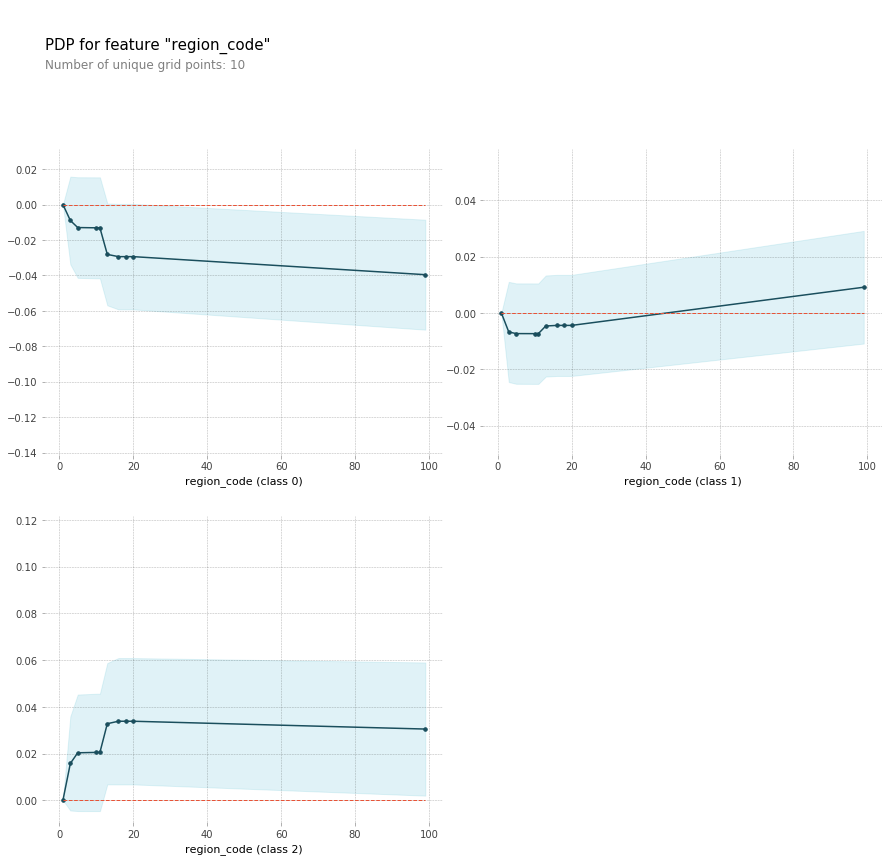

In [22]:
pdp_plot(isolated, feature_name=feature)

In [24]:
dir(isolated)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

(<Figure size 1080x1224 with 7 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f32c7624630>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f32c78994a8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


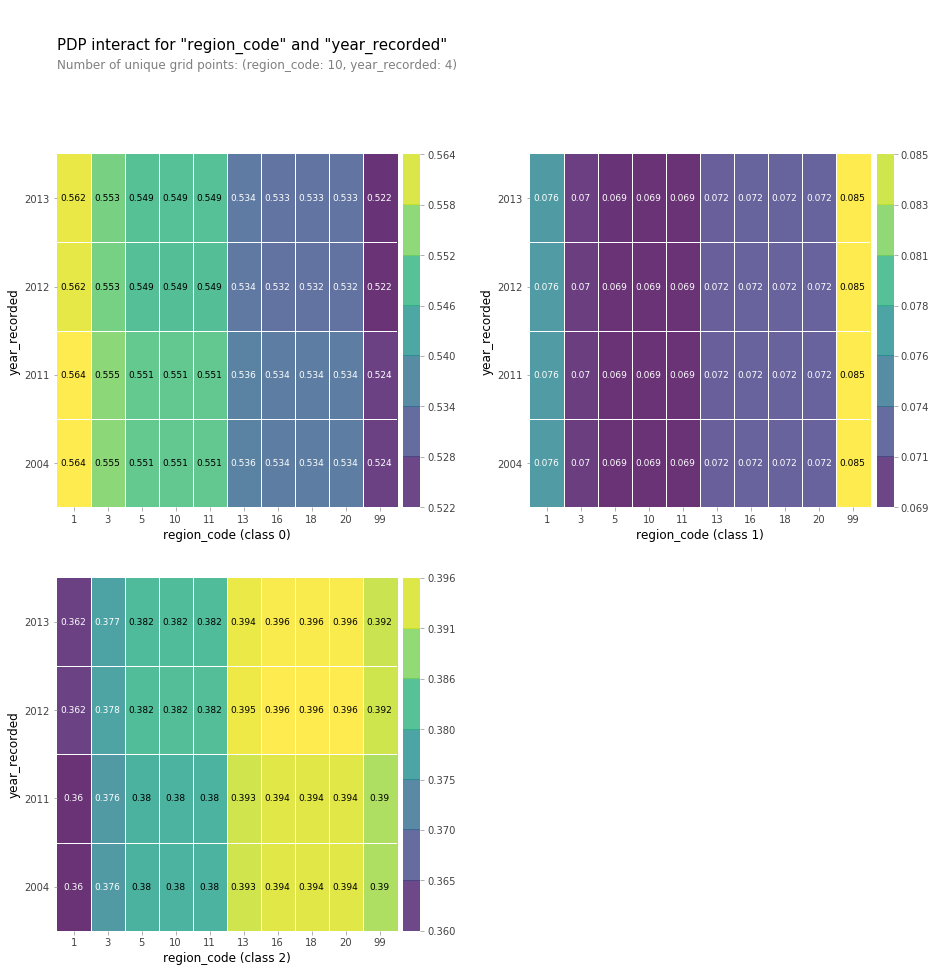

In [27]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['region_code','year_recorded']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [25]:
# Trying to customize 

# grid = isolated.__subclasshook__
# pdp = isolated.pdp

AttributeError: ignored

In [20]:
#This approach isn't working

# feature='quantity'

# isolated = pdp_isolate(
#     model = pipeline,
#     dataset = X_val,
#     model_features = X_val.columns,
#     feature = feature
# )

TypeError: ignored